# Experimento D

Se modifico el modelo para que el output sea el numero de conos sin tener la necesidad de encontrar primeor el density map. Es decir, en comparacion con el experimento 15, este encuentra directo el conteo de conos.

Comparacion:
Suprime el decoder completo y el Conv2D(1) final. Basta con un encoder + bottleneck seguido de global average pooling y capas densas

In [3]:
import os
import numpy as np
import imageio
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device_name = tf.test.gpu_device_name()
print("GPU detectada:", device_name)

GPU detectada: /device:GPU:0


In [6]:
# Rutas de los conjuntos de entrenamiento y validación
train_path = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Training+Density/'
val_path   = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Validation+Density/'

In [7]:
# Función para leer y preprocesar datos
def read_data(base_path, density_threshold=400):
    data = []
    anno = []
    file_list = os.listdir(base_path)
    for filename in file_list:
        if 'Density' in filename:
            base_filename = filename[:-11] + '.tif'
            img_path = os.path.join(base_path, base_filename)
            dens_path = os.path.join(base_path, filename)
            if os.path.exists(img_path) and os.path.exists(dens_path):
                # Cargar imagen y normalizar a [0,1]
                img = np.asarray(Image.open(img_path).convert("RGB")).astype(np.float32) / 255.0
                # Cargar mapa de densidad
                density = imageio.imread(dens_path).astype(np.float32)
                # Filtrado basado en la suma (ajustar el umbral según se requiera)
                if np.sum(density) / 100 < density_threshold:
                    data.append(img)
                    # Expandir la dimensión para que tenga forma (H, W, 1)
                    density = np.expand_dims(density, axis=-1)
                    anno.append(density)
    return np.array(data), np.array(anno)

In [8]:
# Cargar conjuntos de entrenamiento y validación
train_images, train_density_maps = read_data(train_path, density_threshold=400)
val_images, val_density_maps = read_data(val_path, density_threshold=400)

print("Train images shape:", train_images.shape)
print("Train density maps shape:", train_density_maps.shape)
print("Validation images shape:", val_images.shape)
print("Validation density maps shape:", val_density_maps.shape)

<ipython-input-7-342034160>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  density = imageio.imread(dens_path).astype(np.float32)


Train images shape: (184, 256, 256, 3)
Train density maps shape: (184, 256, 256, 1)
Validation images shape: (80, 256, 256, 3)
Validation density maps shape: (80, 256, 256, 1)


La suma de valores se hace con `if np.sum(np.sum(anno[i][:,:,0],0),0)/100`  
- Se asume que la anotación de la densidad de conos está almacenada en el primer canal.
- Se realiza una doble suma de los valores en este canal. -> Suma por fila y por columna.
- El resultado se divide entre 100 (normalización) para luego validar que es menor que 400.

In [9]:
# Cálculo de la cuenta (número de conos) por imagen
# Se usa np.sum sobre el primer canal directamente.
train_counts = [np.sum(dm[:, :, 0]) / 100 for dm in train_density_maps]
val_counts   = [np.sum(dm[:, :, 0]) / 100 for dm in val_density_maps]

# Convertir a arrays y darles forma (N, 1) para el modelo
train_counts = np.array(train_counts).reshape(-1, 1)
val_counts = np.array(val_counts).reshape(-1, 1)

In [10]:
# Función de data augmentation (flip y rotaciones)
def augment(image):
    # Flip horizontal aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
    # Flip vertical aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
    # Rotación aleatoria múltiplo de 90 grados
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    return image

# Crear datasets tf.data para entrenamiento y validación
batch_size = 8

# Dataset de entrenamiento: redimensionamiento, data augmentation y batching.
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_counts))
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, (256, 256)), y))
train_dataset = train_dataset.map(lambda x, y: (augment(x), y))
train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Dataset de validación: solo redimensionamiento y batching.
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_counts))
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, (256,256)), y))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [11]:
def conv_block(x, filters):
    for _ in range(2):
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D()(c)
    return p

inputs = layers.Input((256, 256, 3))

x = encoder_block(inputs, 16)   # 128×128
x = encoder_block(x, 32)        # 64×64
x = encoder_block(x, 64)        # 32×32
x = conv_block(x, 128)          # bottleneck 32×32
x = layers.Dropout(0.5)(x)

# Global pooling + regresión
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)   # opcional capa intermedia
output = layers.Dense(1, name='cone_count')(x)

model = models.Model(inputs, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             

 Total params: 303,761 (1.16 MB)

 Trainable params: 302,801 (1.16 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
# Compilar el modelo
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=['mae'])

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6)
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo usando el pipeline de tf.data
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    callbacks=[early_stop, reduce_lr, checkpoint])


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 18187.5977 - mae: 121.7500

23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - loss: 18213.3418 - mae: 121.8276 - val_loss: 15355.7529 - val_mae: 110.0515 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 18606.2520 - mae: 121.4142

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 18556.3926 - mae: 121.2672 - val_loss: 14908.4746 - val_mae: 107.9957 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17117.2734 - mae: 115.9751

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 17031.3066 - mae: 115.6397 - val_loss: 11193.6816 - val_mae: 89.7514 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12623.2764 - mae: 99.6675 

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 12576.8438 - mae: 99.4428 - val_loss: 8981.7539 - val_mae: 78.6490 - learning_rate: 0.0010
Epoch 5/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7620.7305 - mae: 77.6328

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7604.6943 - mae: 77.3230 - val_loss: 5002.7305 - val_mae: 56.3618 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5580.7183 - mae: 64.1129 - val_loss: 13206.5020 - val_mae: 101.0149 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2559.8242 - mae: 40.0264 - val_loss: 15652.6621 - val_mae: 111.4485 - learning_rate: 0.0010
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1826.1024 - mae: 31.9899 - val_loss: 15501.4238 - val_mae: 110.8527 - learning_rate: 0.0010
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1302.8220 - mae: 27.4057 - val_loss: 13458.7559 - val_mae: 102.5754 - learning_rate: 0.0010
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 986.5021 - mae: 22.6855 - val_loss: 8817.9336 - val_mae: 79.2119 - learning_rate: 0.0010
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1008.3082 - mae: 24.6596 - val_loss: 14996.

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 993.8302 - mae: 22.8836 - val_loss: 3963.4062 - val_mae: 52.9626 - learning_rate: 7.0000e-04
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 848.5373 - mae: 22.0788

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 851.5754 - mae: 22.1174 - val_loss: 3618.3887 - val_mae: 49.4389 - learning_rate: 7.0000e-04
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1105.5149 - mae: 24.6336

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1102.3075 - mae: 24.6126 - val_loss: 1987.0758 - val_mae: 35.4615 - learning_rate: 7.0000e-04
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1042.0846 - mae: 24.3102 - val_loss: 2286.7009 - val_mae: 33.5193 - learning_rate: 7.0000e-04
Epoch 16/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1123.5380 - mae: 25.7028 - val_loss: 3674.1199 - val_mae: 49.2932 - learning_rate: 7.0000e-04
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 705.3323 - mae: 20.4048

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 710.9628 - mae: 20.4577 - val_loss: 1129.7484 - val_mae: 25.3477 - learning_rate: 7.0000e-04
Epoch 18/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1119.9209 - mae: 25.3282 - val_loss: 4089.7297 - val_mae: 53.4515 - learning_rate: 7.0000e-04
Epoch 19/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 740.3792 - mae: 20.7122

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 738.8483 - mae: 20.6574 - val_loss: 819.5057 - val_mae: 22.5324 - learning_rate: 7.0000e-04
Epoch 20/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1367.8925 - mae: 28.1124 - val_loss: 3440.7954 - val_mae: 49.0228 - learning_rate: 7.0000e-04
Epoch 21/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 973.4849 - mae: 23.9439 - val_loss: 3179.4102 - val_mae: 48.0366 - learning_rate: 7.0000e-04
Epoch 22/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 651.4920 - mae: 20.3432 - val_loss: 1781.4170 - val_mae: 36.1738 - learning_rate: 7.0000e-04
Epoch 23/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 708.7609 - mae: 20.6816 - val_loss: 1652.2737 - val_mae: 30.6518 - learning_rate: 7.0000e-04
Epoch 24/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 724.5874 - mae: 21.1770 - val_loss: 833.5341 - val_mae: 23.0216 - learning_rate: 7.0000e-04
Epoch 25/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 691.4896 - mae: 20.9891 - val

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 504.2610 - mae: 17.5979 - val_loss: 697.5529 - val_mae: 22.0862 - learning_rate: 4.9000e-04
Epoch 27/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 945.3741 - mae: 24.0629

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 940.8635 - mae: 23.9935 - val_loss: 520.1377 - val_mae: 17.5926 - learning_rate: 4.9000e-04
Epoch 28/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 589.1144 - mae: 18.0934 - val_loss: 2390.0601 - val_mae: 38.2560 - learning_rate: 4.9000e-04
Epoch 29/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 575.7076 - mae: 18.0114 - val_loss: 2798.5952 - val_mae: 40.6029 - learning_rate: 4.9000e-04
Epoch 30/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 738.3138 - mae: 18.3578

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 764.1278 - mae: 18.5890 - val_loss: 463.9551 - val_mae: 15.9624 - learning_rate: 4.9000e-04
Epoch 31/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 758.3633 - mae: 21.2517 - val_loss: 959.0246 - val_mae: 24.7172 - learning_rate: 4.9000e-04
Epoch 32/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 907.6304 - mae: 23.6732 - val_loss: 1248.1467 - val_mae: 25.6497 - learning_rate: 4.9000e-04
Epoch 33/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 683.4175 - mae: 20.5243 - val_loss: 629.7784 - val_mae: 19.0034 - learning_rate: 4.9000e-04
Epoch 34/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 974.3423 - mae: 22.6737 - val_loss: 1184.2375 - val_mae: 27.7315 - learning_rate: 4.9000e-04
Epoch 35/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 542.6171 - mae: 16.9653

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 546.2007 - mae: 17.0417 - val_loss: 454.0084 - val_mae: 16.7654 - learning_rate: 4.9000e-04
Epoch 36/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 686.2668 - mae: 20.1211 - val_loss: 705.7593 - val_mae: 20.1837 - learning_rate: 4.9000e-04
Epoch 37/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 879.9587 - mae: 23.3621 - val_loss: 542.3152 - val_mae: 16.1160 - learning_rate: 4.9000e-04
Epoch 38/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 433.8479 - mae: 15.6135 - val_loss: 1650.2057 - val_mae: 30.6036 - learning_rate: 4.9000e-04
Epoch 39/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 663.5126 - mae: 20.6484 - val_loss: 632.4233 - val_mae: 17.5288 - learning_rate: 4.9000e-04
Epoch 40/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 561.7565 - mae: 18.0267 - val_loss: 534.9920 - val_mae: 17.0695 - learning_rate: 4.9000e-04
Epoch 41/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 770.0676 - mae: 21.4051 - val_los

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 443.7719 - mae: 16.7379 - val_loss: 454.0037 - val_mae: 17.0146 - learning_rate: 3.4300e-04
Epoch 45/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1116.3800 - mae: 27.8040 - val_loss: 494.1931 - val_mae: 17.2609 - learning_rate: 3.4300e-04
Epoch 46/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 606.1879 - mae: 18.5620 - val_loss: 617.8329 - val_mae: 18.4592 - learning_rate: 3.4300e-04
Epoch 47/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 460.1809 - mae: 15.7391 - val_loss: 500.7246 - val_mae: 16.9779 - learning_rate: 3.4300e-04
Epoch 48/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 471.4798 - mae: 17.5533 - val_loss: 647.2598 - val_mae: 18.9445 - learning_rate: 3.4300e-04
Epoch 49/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 581.9700 - mae: 18.2437 - val_loss: 955.0339 - val_mae: 25.1430 - learning_rate: 3.4300e-04
Epoch 50/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 586.4703 - mae: 18.6972

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 583.8400 - mae: 18.6557 - val_loss: 411.6496 - val_mae: 15.0260 - learning_rate: 2.4010e-04
Epoch 51/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 687.2440 - mae: 20.9635

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 686.7466 - mae: 20.9622 - val_loss: 385.8627 - val_mae: 14.8854 - learning_rate: 2.4010e-04
Epoch 52/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 726.1704 - mae: 18.7530 - val_loss: 465.1086 - val_mae: 16.5423 - learning_rate: 2.4010e-04
Epoch 53/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 428.7718 - mae: 16.1873 - val_loss: 529.3996 - val_mae: 16.7288 - learning_rate: 2.4010e-04
Epoch 54/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 768.8998 - mae: 21.8033 - val_loss: 497.0219 - val_mae: 16.5534 - learning_rate: 2.4010e-04
Epoch 55/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 875.4929 - mae: 20.6116 - val_loss: 389.1133 - val_mae: 14.9876 - learning_rate: 2.4010e-04
Epoch 56/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 819.4401 - mae: 21.7555 - val_loss: 902.6676 - val_mae: 25.8142 - learning_rate: 2.4010e-04
Epoch 57/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 509.5440 - mae: 16.7809 - val_loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 454.8095 - mae: 16.7144 - val_loss: 345.3935 - val_mae: 14.1998 - learning_rate: 1.6807e-04
Epoch 60/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 439.7484 - mae: 16.6923

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 442.0509 - mae: 16.7211 - val_loss: 312.5770 - val_mae: 13.2093 - learning_rate: 1.6807e-04
Epoch 61/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 788.6003 - mae: 22.2957 - val_loss: 329.4048 - val_mae: 13.5064 - learning_rate: 1.6807e-04
Epoch 62/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 471.5257 - mae: 16.3666 - val_loss: 426.9954 - val_mae: 14.5498 - learning_rate: 1.6807e-04
Epoch 63/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 511.4145 - mae: 17.3936 - val_loss: 501.9790 - val_mae: 16.9244 - learning_rate: 1.6807e-04
Epoch 64/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 635.6514 - mae: 19.6501 - val_loss: 718.8861 - val_mae: 22.0056 - learning_rate: 1.6807e-04
Epoch 65/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 791.4189 - mae: 21.9282 - val_loss: 390.9958 - val_mae: 15.1323 - learning_rate: 1.6807e-04
Epoch 66/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 482.7878 - mae: 17.6091 - val_loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 290.7176 - mae: 12.7600 - val_loss: 301.7909 - val_mae: 13.2088 - learning_rate: 5.7648e-05
Epoch 77/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 480.2465 - mae: 16.7922 - val_loss: 325.0514 - val_mae: 13.1202 - learning_rate: 5.7648e-05
Epoch 78/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 422.2939 - mae: 14.7327 - val_loss: 384.9282 - val_mae: 14.7043 - learning_rate: 5.7648e-05
Epoch 79/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 370.1389 - mae: 15.4429

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 371.7276 - mae: 15.4409 - val_loss: 286.5822 - val_mae: 12.3976 - learning_rate: 5.7648e-05
Epoch 80/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 493.8939 - mae: 16.8402 - val_loss: 290.5457 - val_mae: 12.3655 - learning_rate: 5.7648e-05
Epoch 81/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 315.3386 - mae: 13.6256

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 318.4547 - mae: 13.6818 - val_loss: 285.7110 - val_mae: 12.3785 - learning_rate: 5.7648e-05
Epoch 82/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 704.2711 - mae: 21.2469 - val_loss: 347.6793 - val_mae: 13.7021 - learning_rate: 5.7648e-05
Epoch 83/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 490.1932 - mae: 17.0567 - val_loss: 387.7025 - val_mae: 14.1777 - learning_rate: 5.7648e-05
Epoch 84/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 368.8257 - mae: 14.2541 - val_loss: 353.9603 - val_mae: 13.3835 - learning_rate: 5.7648e-05
Epoch 85/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 477.0938 - mae: 16.3076 - val_loss: 350.0499 - val_mae: 13.3173 - learning_rate: 5.7648e-05
Epoch 86/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 440.9562 - mae: 16.3492 - val_loss: 323.9826 - val_mae: 13.3771 - learning_rate: 5.7648e-05
Epoch 87/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 825.2549 - mae: 21.4011 - val_loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 258.5453 - mae: 11.9709 - val_loss: 284.2934 - val_mae: 12.4106 - learning_rate: 1.9773e-05
Epoch 99/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 499.8475 - mae: 16.5552 - val_loss: 289.1902 - val_mae: 12.5344 - learning_rate: 1.9773e-05
Epoch 100/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 628.7957 - mae: 19.2383 - val_loss: 296.5086 - val_mae: 12.4281 - learning_rate: 1.9773e-05


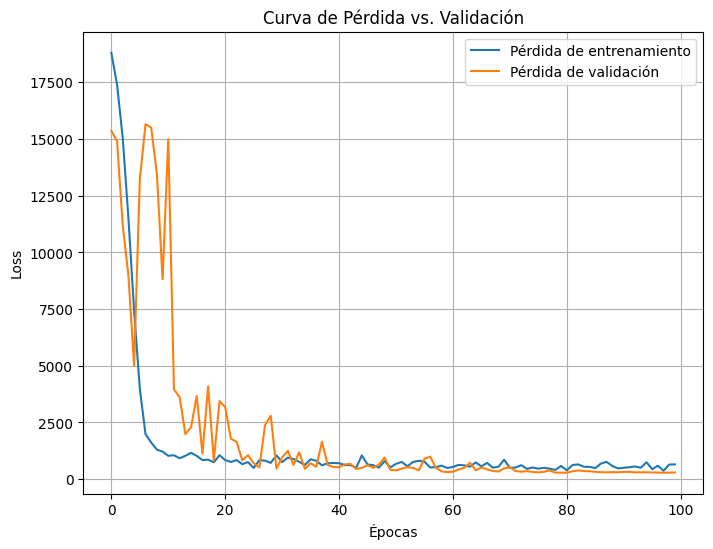

In [13]:
# Visualización de la curva de entrenamiento
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Pérdida vs. Validación')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Evaluación del modelo
model.load_weights('ModelD.h5')
val_loss, val_mae = model.evaluate(val_dataset)
print(f"Validación - MSE: {val_loss:.3f}, MAE: {val_mae:.3f}")

# Predicción y visualización de resultados en un ejemplo de validación
# Se toma un batch y se selecciona la segunda imagen del batch (índice 1)
for test_imgs, true_counts_batch in val_dataset.take(1):
    test_img_sample = test_imgs[1]
    true_count_sample = true_counts_batch[1]

# Dado que el modelo devuelve un valor escalar (conteo), se predice directamente
predicted_count = model.predict(tf.expand_dims(test_img_sample, axis=0)).squeeze()

# Convertir a escalar si es necesario
true_count_scalar = true_count_sample.item() if hasattr(true_count_sample, 'item') else true_count_sample
predicted_count_scalar = predicted_count.item() if hasattr(predicted_count, 'item') else predicted_count

true_count_scalar, predicted_count_scalar

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 187.7068 - mae: 11.0817
Validación - MSE: 173.568, MAE: 10.440
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([54.], dtype=float32)>,
 54.07334899902344)

**Metricas de evaluacion**

In [16]:
val_dataset.element_spec #shape

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [17]:
from sklearn.metrics import r2_score

y_true, y_pred = [], []

# Recorremos todo el validation set sin alterar el grafo
for batch_x, batch_y in val_dataset:
    preds = model(batch_x, training=False)
    y_true.append(batch_y.numpy().ravel())
    y_pred.append(preds.numpy().ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Métricas
mae  = np.mean(np.abs(y_true - y_pred))
mse  = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2   = r2_score(y_true, y_pred)
corr = np.corrcoef(y_true, y_pred)[0,1]

print(f"MAE : {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f} %")
print(f"R²  : {r2:.3f}")
print(f"ρ   : {corr:.3f}")

MAE : 10.440
MSE: 173.568
RMSE: 13.175
MAPE: 17.08 %
R²  : 0.947
ρ   : 0.973


In [19]:
true_count_val = float(true_count_sample.numpy()[0])
predicted_count_val = float(predicted_count)
print(f"Conteo real: {true_count_val:.2f} | Conteo predicho: {predicted_count_val:.2f}")

Conteo real: 54.00 | Conteo predicho: 54.07


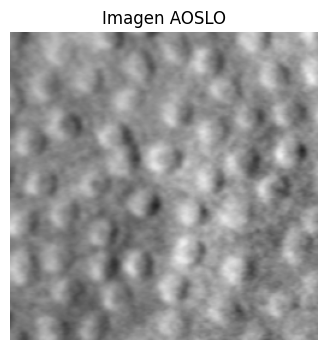

In [20]:
# Visualización: se muestran la imagen de entrada y los resultados en un panel
plt.figure(figsize=(12,4))

plt.subplot(1,1,1)
plt.imshow(test_img_sample)
plt.title("Imagen AOSLO")
plt.axis('off')

plt.show()

Bland Almant V2

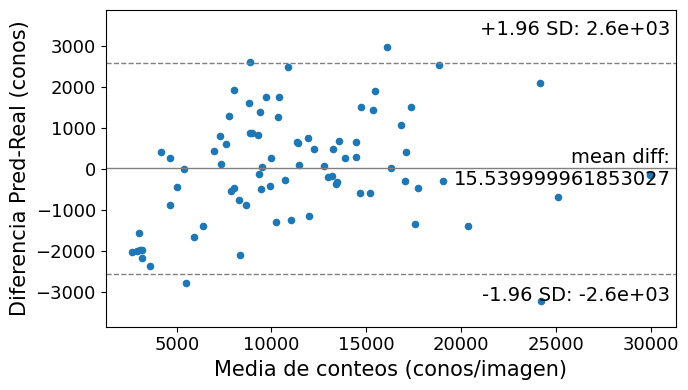

Bias (media de d): -0.16
LoA 95%: [-26.14, 25.83] conos -> Límites de acuerdo (LoA, Limits of Agreement) 


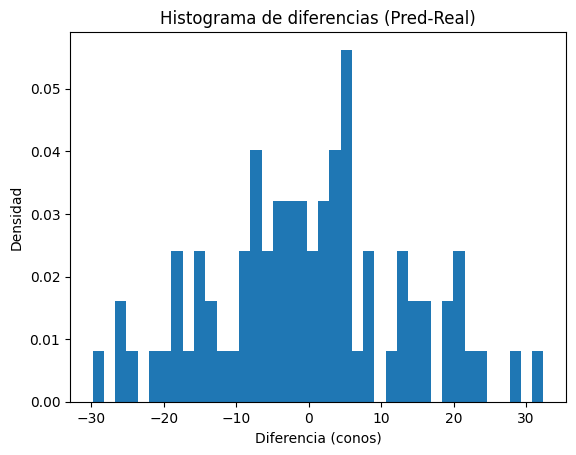

In [21]:
# --- Bland-Altman ---
mean_vals = (y_true + y_pred)/2
diff_vals = y_pred - y_true
mean_diff  = diff_vals.mean()
sd_diff    = diff_vals.std(ddof=1)

scale = 100
true_raw = y_true * scale
pred_raw = y_pred * scale

fig, ax = plt.subplots(figsize=(7,4))
sm.graphics.mean_diff_plot(true_raw, pred_raw, ax=ax)  # hace scatter + líneas LoA
ax.set_xlabel('Media de conteos (conos/imagen)')
ax.set_ylabel('Diferencia Pred-Real (conos)')
plt.show()

print(f"Bias (media de d): {mean_diff:.2f}")
print(f"LoA 95%: [{mean_diff-1.96*sd_diff:.2f}, {mean_diff+1.96*sd_diff:.2f}] conos -> Límites de acuerdo (LoA, Limits of Agreement) ")

# --- Histograma de diferencias ---
plt.figure()
plt.hist(diff_vals, bins=40, density=True)
plt.title('Histograma de diferencias (Pred-Real)')
plt.xlabel('Diferencia (conos)')
plt.ylabel('Densidad')
plt.show()

En un análisis de Bland-Altman:

	1.	Bias (d̄)
	•	Es la media de las diferencias d_i = \hat y_i - y_i.
	•	Mide el sesgo sistemático: cuánto, en promedio, tu modelo sobre- o sub-estima el conteo real.

	2.	Desviación estándar de las diferencias (SD_d)
	•	Describe la dispersión de esos errores.
  
	3.	Límites de acuerdo (LoA, Limits of Agreement)
	•	Bajo la suposición de distribución aproximadamente normal de d_i, ≈ 95 % de las observaciones caerán dentro de ese intervalo.

Los ejes cambian mucho en comparacion con los modelos que predicen un density map puesto que el Bland Altman de estos nos da conos/mm2 mientras que el presente bland altman es de conos/imagen. Ademas:  

En muchos scripts de conteo se genera el ground-truth así:
`density[y, x] = 100` -> # o 255, o 1/πσ²…

	•	El pico gaussiano se normaliza para que su integral sea 1 (o 100)
	•	Luego, al integrarlo sobre todo el mapa obtienes N_conos (o N_conos × 100).

En el presente condigo se divide validacion entre 100:
`val_counts.append( np.sum(density_map) / 100 )`

esto no se hace en el density map de los otros codigos.


In [24]:
# Raw scale (multiply by 100)
y_true_raw = y_true * 100
y_pred_raw = y_pred * 100

mae_raw = np.mean(np.abs(y_true_raw - y_pred_raw))
mse_raw = np.mean((y_true_raw - y_pred_raw)**2)
rmse_raw = np.sqrt(mse_raw)
mape_raw = np.mean(np.abs((y_true_raw - y_pred_raw) / (y_true_raw + 1e-10))) * 100
r2_raw = r2_score(y_true_raw, y_pred_raw)  # R² is scale-invariant

print("\nRaw Scale (counts):")
print(f"MAE : {mae_raw:.3f}")
print(f"MSE: {mse_raw:.3f}")
print(f"RMSE: {rmse_raw:.3f}")
print(f"MAPE: {mape_raw:.2f}%")
print(f"R²  : {r2_raw:.3f}")


Raw Scale (counts):
MAE : 1043.950
MSE: 1735681.625
RMSE: 1317.453
MAPE: 17.08%
R²  : 0.947
